<a href="https://colab.research.google.com/github/carlibeisel/pod_pou_lulcc/blob/main/01_diversion_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modified by Carli Beisel

Adapted from code written by Bridget Bittmann (2023, Github: bridgetmarie24)

Date originally created: March 14, 2022

Date modified: April 16, 2024


This script takes daily irrigation season flow values for the diversions and calculates:

1) total water diverted

2) start day of irrigation season

3) end day of irrigation season

4) length of irrigation season.

It corrects for diversions that would go beyond the bounds of a true irrigation season (e.g., February).

In [ ]:
#Import necessary packages

import pandas as pd #to work with data arrays
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs
from matplotlib.dates import DateFormatter #to help with timeseries
import glob #to batch import csv files
from sklearn import metrics #to find r2 values from regression
!pip install pymannkendall
import pymannkendall as mk #used to perform mann-kendall stationarity test
from sklearn.cluster import KMeans #to cluster using kmeans
import os #for file output paths
import matplotlib.patches as mpatches
import matplotlib.lines as Line2D
import seaborn as sns

In [ ]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## IMPORT ALL DIVERSION FILES ##

all_files =[]
csv = glob.glob('/content/drive/MyDrive/Data/Datasets from Bridget/pod_pou_lulcc/diversion_timeseries/WRA_20220712_db206/*_history.csv')
common_name_flow = pd.read_csv('/content/drive/MyDrive/Data/Datasets from Bridget/pod_pou_lulcc/diversion_timeseries/relates/name_dictionary_flow.csv')
names = list(common_name_flow['DiversionName'])
div_dict = dict(zip(common_name_flow['HydrologyID'], common_name_flow['DiversionName']))

for f in csv:
  df = pd.read_csv(f, parse_dates=['HSTDate'], index_col=False)
  all_files.append(df)

full = pd.concat(all_files)
full['Name'] = full['SiteID'].map(div_dict)
full = full.drop(['SiteType', 'Gage Height (Feet)', 'Unnamed: 6', 'Unnamed: 5'],
                 axis=1).rename({'Flow (CFS)': 'Diversion (cfs)',
                                 'HSTDate': 'DataDate'}, axis=1).sort_values(by='Name')
full['Acre_feet'] = full['Diversion (cfs)']*86400/43559.9

In [ ]:
## DATA QUALITY CONTROL PRIOR TO ANALYSIS ##

## Find the names of all the canals in the dataframe list

names = full['Name'].unique()

## Fill in any missing winter values with 0 starting at 1987-01-01

full = full.set_index('DataDate')
dt_series = pd.date_range(start='1987-01-01', end='1987-01-31', freq = 'D' )
dt_df = pd.DataFrame(dt_series, index=dt_series)

canals = []

for i in names:
  canal = full[full['Name']== i] #selects the specific diversion dataframe
  if canal.empty:
    None
  else:
    id = canal['SiteID'][0]
    canal = pd.concat([dt_df, canal]) #adds the pandas series of dates to dataframe
    canal = canal.drop(labels=0, axis=1) #dropes the series column
    canal = canal.loc[~canal.index.duplicated(),:] #removes any duplicate index values
    canal = canal.asfreq('d') #fill each daily value
    canal['Diversion (cfs)'] = canal['Diversion (cfs)'].fillna(value=0) #fills CFS Nan values with 0, assumed during winter months or no data
    canal['Diversion (cfs)'] = canal['Diversion (cfs)'].abs()
    canal['Name'] = canal['Name'].fillna(i) #fills Nan diversion name values
    canal['SiteID'] = canal['SiteID'].fillna(id)
    canal['Acre_feet'] = canal['Acre_feet'].fillna(0)
    canals.append(canal)

In [ ]:
## ----------------------------- ##
## MERGE ALL DATAFRAMES INTO ONE ##
## ----------------------------- ##

full_df = pd.concat(canals)
names = full_df['Name'].unique()

full_df['Year'] = full_df.index.year
full_df['Month'] = full_df.index.month
full_df['DayofYear'] = full_df.index.dayofyear
full_df = full_df[full_df['Year'] <= 2021]

In [ ]:
## -------------------------------- ##
## Survival Analysis Data Gathering ##
## -------------------------------- ##

# Calculate the cumulative sum of the data

full_df['Sum'] = full_df.groupby(['Name','Year']).Acre_feet.cumsum()

# Calculate the start and end day of the irrigation season for each canal

names = full_df['Name'].unique()
years = full_df['Year'].unique()
df_start = pd.DataFrame()
df_end = pd.DataFrame()

for i in names:
  sub = full_df[full_df['Name'] == i]
  for y in years:
    sub_year = sub[sub['Year'] == y]
    start = sub_year.loc[sub_year['Sum']>0].sort_values(by = 'DayofYear').head(1) # day when the flow value is greater than 0
    df_start = pd.concat([df_start,start]) # add this to continuous dataframe
    end = sub_year.loc[sub_year['Sum'] == max(sub_year['Sum'])].head(1) # day when cumulative flow is the max value
    df_end = pd.concat([df_end,end])

df_start = df_start.reset_index()
df_end = df_end.reset_index()

df_start = df_start[['index', 'Year', 'Name', 'DayofYear']].rename({'index': 'StartDate',
                                                                    'DayofYear': 'StartDayofYear'}, axis = 1)
df_end = df_end[['index', 'Year', 'Name', 'DayofYear']].rename({'index': 'EndDate',
                                                                'DayofYear': 'EndDayofYear'}, axis = 1)

# Create a dataframe used for survival analysis
survival = df_start.merge(df_end, left_on = ['Name', 'Year'], right_on = ['Name', 'Year'])
survival['Time'] = survival['EndDayofYear'] - survival['StartDayofYear'] # time to event
survival.loc[survival['StartDayofYear'] < 60, 'Censor'] = 'Left' # left censored
survival.loc[survival['EndDayofYear'] > 319, 'Censor'] = 'Right' # right censored
survival.loc[(survival['EndDayofYear'] < 319) & (survival['StartDayofYear'] > 60), 'Censor'] = 'No' # No censor


In [ ]:
## Cropping start and end of irrigation season ##
## ------------------------------------------- ##

# Determine the earliest start dates after Mar. 1
# and the latest end dates before Nov. 15

s_dates = pd.DataFrame()
e_dates = pd.DataFrame()

for i in survival['Year'].unique():
  sub = survival[survival['Year'] == i]
  s_dates = pd.concat([s_dates, sub.loc[sub['StartDayofYear'] > 60].sort_values(by = 'StartDayofYear').head(1)])
  e_dates = pd.concat([e_dates, sub.loc[sub['EndDayofYear'] < 319].sort_values(by = 'EndDayofYear', ascending = False).head(1)])

# Merge into one dataframe

s_dates = s_dates[['StartDate', 'StartDayofYear', 'Year', 'Name']].rename({'Name' : 'Name_start'},
                                                                          axis = 1)
e_dates = e_dates[['EndDate', 'EndDayofYear', 'Year', 'Name']].rename({'Name' : 'Name_end'},
                                                                      axis = 1)
se_dates = s_dates.merge(e_dates, on='Year')

se_dates.to_csv('/content/drive/MyDrive/Data/Datasets from Bridget/pod_pou_lulcc/diversion_timeseries/relates/se_dates_102622.csv')


In [ ]:
## Clip the irrigation seaosn to the min and max dates for each year ##
start_end = pd.read_csv('/content/drive/MyDrive/Data/Datasets from Bridget/pod_pou_lulcc/diversion_timeseries/relates/se_dates_102622.csv', parse_dates=['StartDate', 'EndDate'])

cropped = []
for i in start_end['Year']:
  sub = full_df[full_df['Year'] == i]
  start = int(start_end['StartDayofYear'][start_end['Year']==i])
  end = int(start_end['EndDayofYear'][start_end['Year']==i])
  sub = sub[sub['DayofYear'] > start]
  sub = sub[sub['DayofYear'] < end]
  cropped.append(sub)

full_df = pd.concat(cropped)


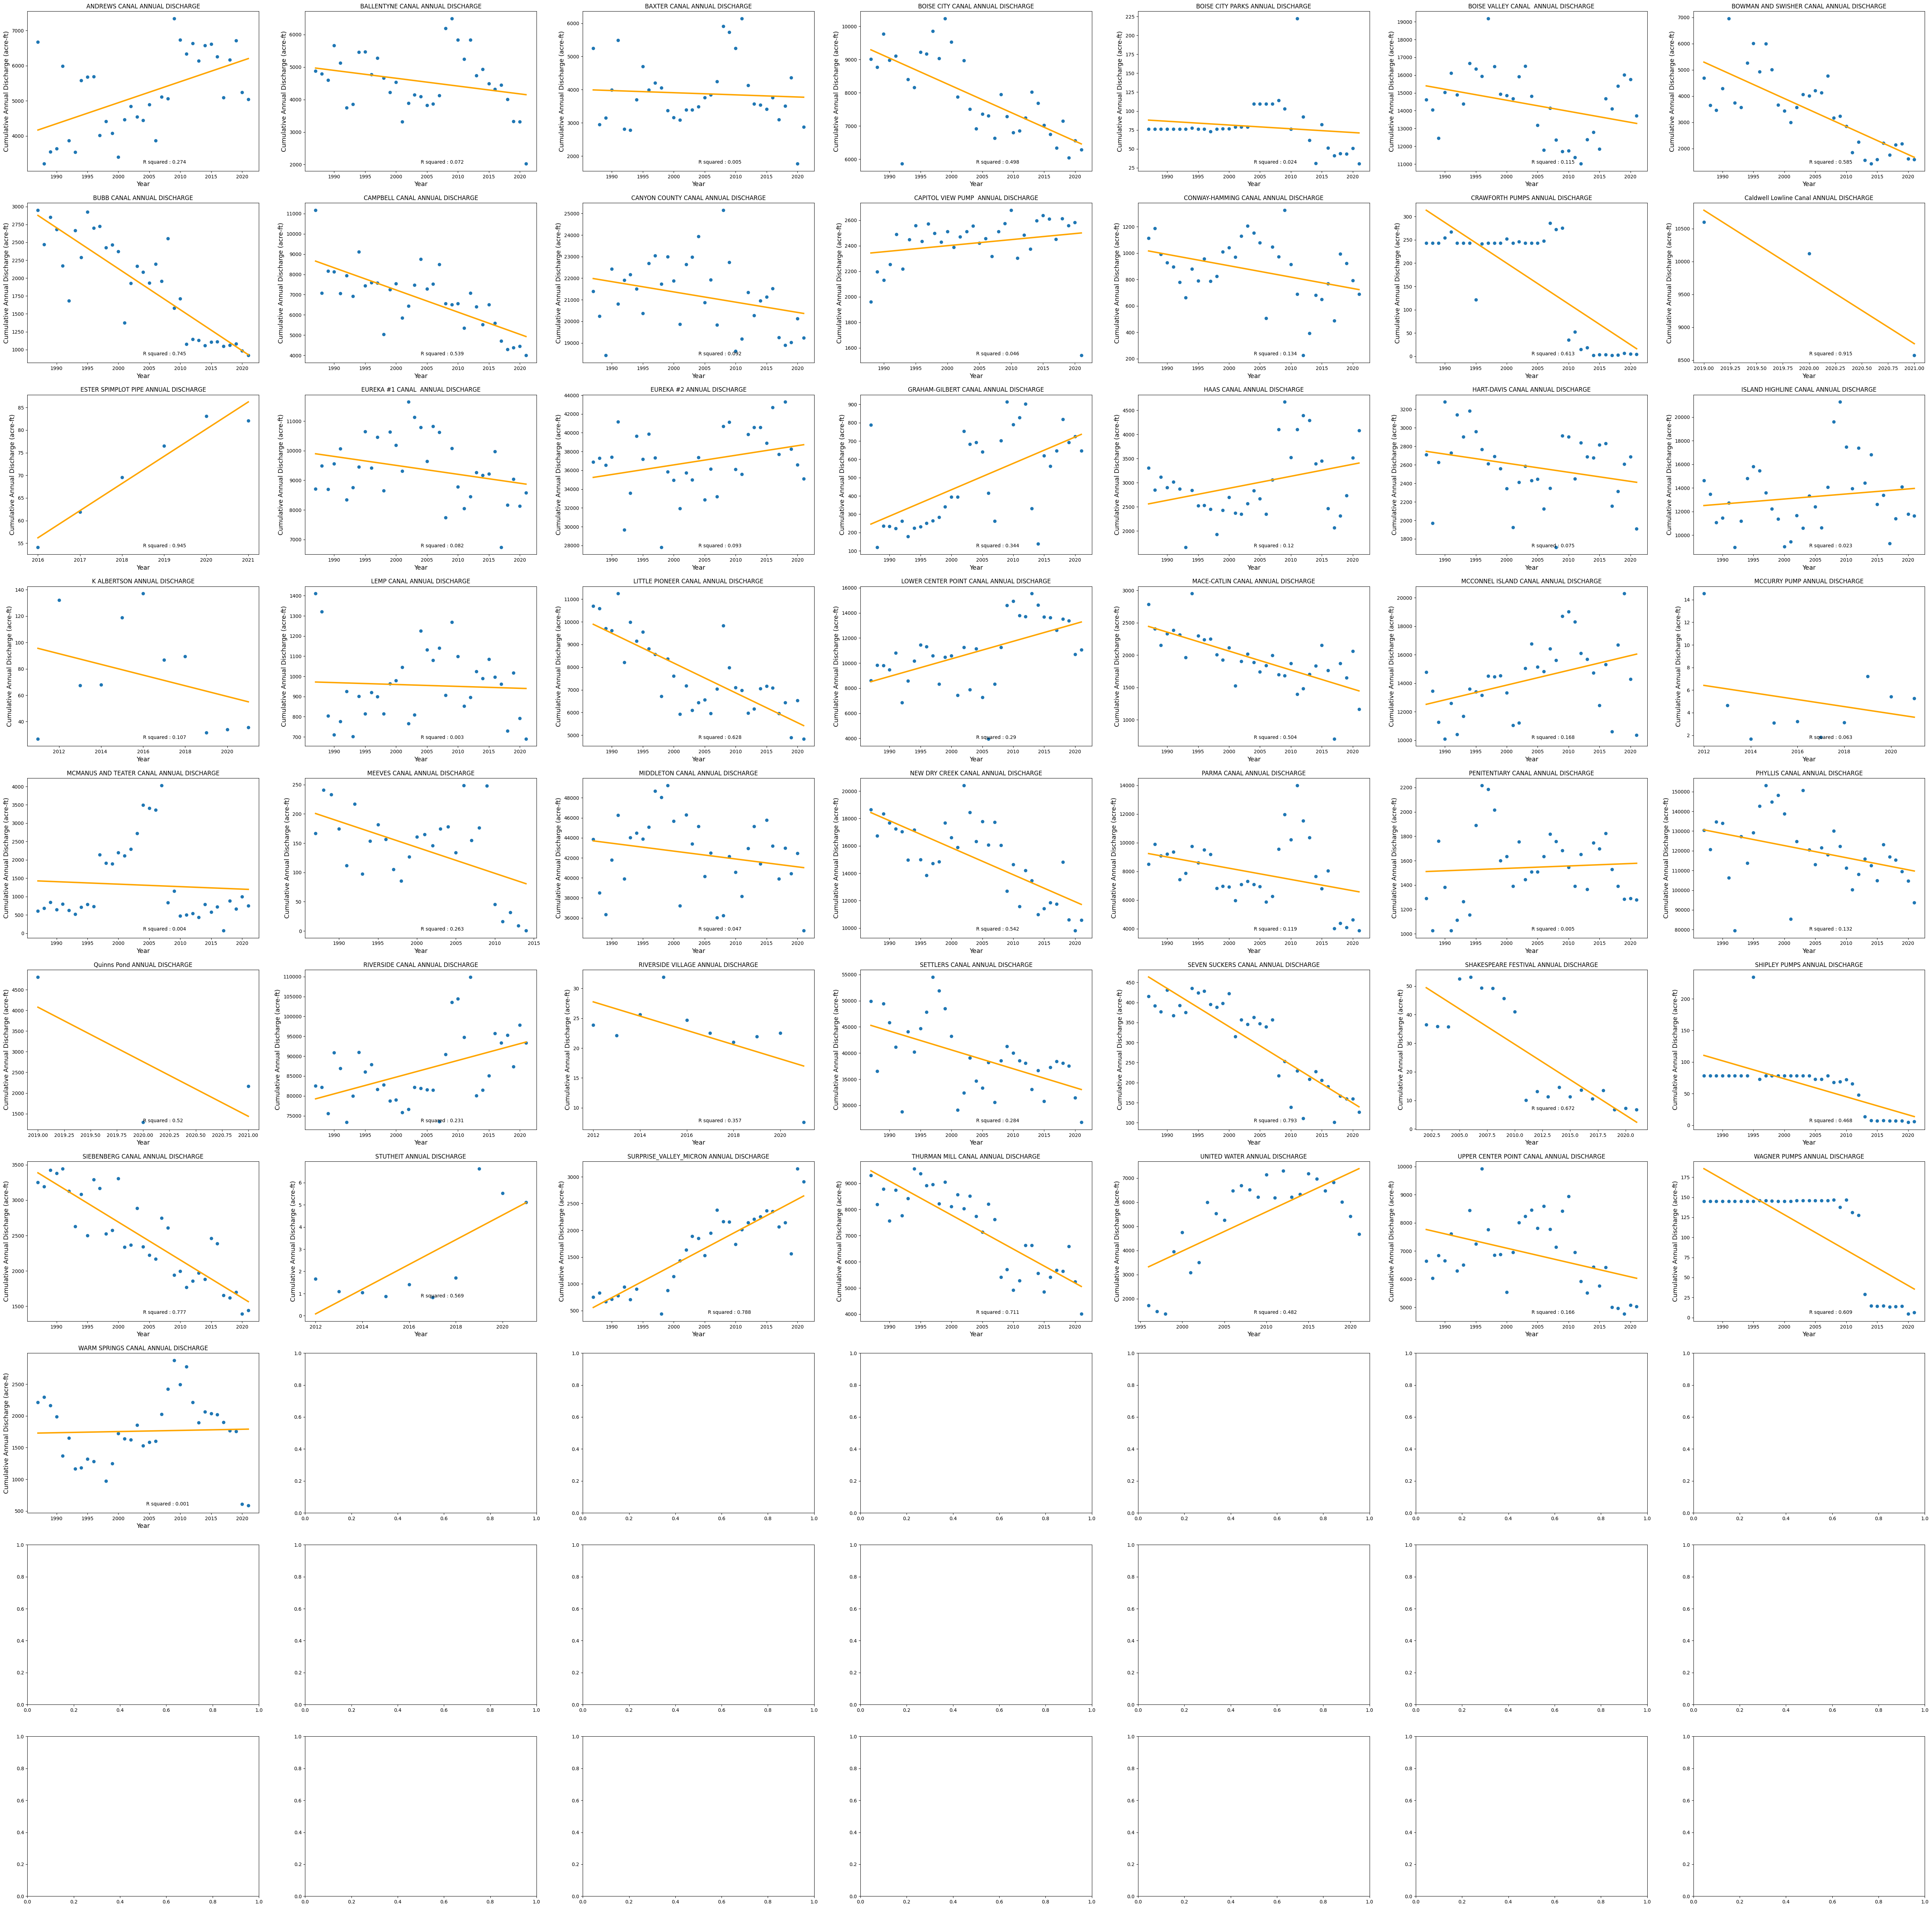

In [ ]:
### FIND THE TOTAL WATER DIVERTED ANNUALLY ###
#I changed the output names, and added an ou

tot = full_df.groupby([full_df['Year'],'Name']).sum(['Acre_feet'])   \
      .sort_values('Name').reset_index().rename(columns={'level_0':'Year'}).sort_values(['Name','Year'])  \
      .reset_index() #use group by to sum the daily values and drop extra columns
tot.loc[tot['Acre_feet'] == 0, 'Acre_feet'] = np.nan
tot = tot.drop(columns=['index'],axis=1).dropna().reset_index().drop(columns = ['index'], axis = 1)
names = tot['Name'].unique()

tot.to_csv('/content/drive/MyDrive/Data/Datasets from Bridget/pod_pou_lulcc/diversion_timeseries/output/diversion_flow_totals.csv', index=False) #save as .csv file

## CALCULATE A REGRESSION FOR EACH DRAIN ##

regress = []
rsquared = np.empty(len(names))

for i in range(len(names)):
  df = pd.DataFrame(tot[tot['Name']==names[i]])
  mod = np.polyfit(df['Year'].values, df['Acre_feet'].values, deg=1) #calculates model coefficients
  df['Model'] = np.polyval(mod, df['Year'].values) #calculate model output values
  rsquared[i] = metrics.r2_score(df['Acre_feet'].values, df['Model'].values) #calculate rsquared for model
  regress.append(df)

regression= pd.concat(regress) #put list of dataframes into one

## CREATE SUBPLOTS FOR THE CHART ##

i,j = 0,0
plot_row = 7 #number of plots per row in figure
figure, ax = plt.subplots(10, plot_row, figsize=(70,70)) #create the figure

for n in range(len(names)): #run a for loop to add all plots to figure
  canal = regression[regression['Name']==names[n]]
  ax[i][j].plot(canal['Year'], canal['Acre_feet'], 'o')
  ax[i][j].plot(canal['Year'], canal['Model'], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Cumulative Annual Discharge (acre-ft)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' ANNUAL DISCHARGE')
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(np.median(canal['Year']), np.min(canal['Acre_feet']), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('/content/drive/MyDrive/Data/Datasets from Bridget/pod_pou_lulcc/diversion_timeseries/output/diversion_flow_totals.png')

In [ ]:
# Basic volume and timing stats #

vol_stat = full_df.groupby('Name').Acre_feet.agg(['mean', 'std']).reset_index().rename({'mean' : 'Avg Daily',
                                                                                        'std' : 'SD Daily'},
                                                                                      axis = 1)
tot_stat = tot.groupby('Name').Acre_feet.agg(['mean', 'std']).reset_index().rename({'mean' : 'Avg Total',
                                                                                    'std' : 'SD Total'},
                                                                                   axis = 1)
start_stat = survival.groupby('Name').StartDayofYear.agg(['mean', 'std']).reset_index().rename({'mean' : 'Avg Start',
                                                                                                'std' : 'SD Start'},
                                                                                              axis = 1)
end_stat = survival.groupby('Name').EndDayofYear.agg(['mean', 'std']).reset_index().rename({'mean' : 'Avg End',
                                                                                            'std' : 'SD End'},
                                                                                            axis = 1)

# Merge and export the files

stats = vol_stat.merge(tot_stat, on = 'Name', how = 'outer')
stats = stats.merge(start_stat, on = 'Name', how = 'outer')
stats = stats.merge(end_stat, on = 'Name', how = 'outer')

stats.to_csv('/content/drive/MyDrive/Data/Datasets from Bridget/pod_pou_lulcc/diversion_timeseries/output/all_stats.csv')

In [ ]:
## --------------------------------------------------- ##
## EXPORT ANNUAL STATS (VOLUME AND TIMING) IN ONE FILE ##
## --------------------------------------------------- ##

out = tot.merge(survival, on = ['Year', 'Name'], how = 'outer', indicator = True)
out.to_csv('/content/drive/MyDrive/Data/Datasets from Bridget/pod_pou_lulcc/diversion_timeseries/output/model_inputs.csv') #EDIT for new ouput location
